In [10]:
# Genetic Algorithm Class for hyperparamter optimisation
#          generate_inital_population()
#          run()
#               evaluate_fitness()
#               selection()
#               crossover()
#               generate_random_chromosome()
#               mutate_population()
#          plot_fitness_scores()


import random
import numpy as np
import kf_ml_lib as kf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

class kf_genetic_algorithm:
    def __init__(self, classifier, dataset_path, population_size, generations):
        self.classifier = classifier
        self.population_size = population_size
        self.generations = generations
        #self.mutation_probability = mutation_probability
        
        self.population = []
        self.best_generation_fitness_scores = []
        self.best_generation_chromosomes = []
        
        # Gene pool
        # Set options and constraints for the selected classifier's hyperparameters
        if self.classifier == "DecisionTreeClassifier":
            self.criterions = ['gini', 'entropy']
            self.splits = ['best', 'random']
            self.min_samples_splits = dict(low = 2, high = 5)
            self.min_samples_leafs = dict(low = 1, high = 4)
            self.min_weight_fraction_leafs = dict(low = 0.0, high = 0.5)
            self.class_weights = ['balanced', None]
        elif self.classifier == 'RandomForestClassifier':
            self.n_estimators = dict(low = 10, high = 200)
            self.criterions = ['gini', 'entropy']
            self.min_samples_splits = dict(low = 2, high = 5)
            self.min_samples_leafs = dict(low = 1, high = 4)
            self.min_weight_fraction_leafs = dict(low = 0.0, high = 0.5)
            self.class_weights = ['balanced', None]
        else:
            raise Exception("Classifier not supported")
                
        # Generate inital chromosome population, with size population_size
        self.population = self.generate_inital_population()
        
        
        # Load, process and split dataset
        self.dataset = kf.load_dataset(dataset_path)
        self.X, self.y = kf.split_dataset(self.dataset, extended=False)

        #self.y = np.split(self.y, 1)
        #self.y = np.array(self.y)
        #self.y = self.y.reshape(len(self.y[0]), 1)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size=0.7, stratify=self.y)
        
    
    def __del__(self):
        print("\nDestroying ga object\n")

        
    # Function to generate an inital random population of chromosomes, given a population_size
    def generate_inital_population(self):
        print("Generating Population of size: ", self.population_size)
        
        # Inital chromosome population
        population = []
        
        # First chromosome with default parameters
        #chromosome = []
        #chromosome.append('gini')
        #chromosome.append('best')
        #chromosome.append(2)
        #chromosome.append(1)
        #chromosome.append(0.0)
        #chromosome.append(None)
        
        #population.append(chromosome)
        
        
        # Fill each chromosome with randomly selected genes from the classifier's gene pools 
        # and add it to the population
        for i in range(0, self.population_size):
            chromosome = []
            
            if self.classifier == 'DecisionTreeClassifier':
                chromosome.append(random.choice(self.criterions))
                chromosome.append(random.choice(self.splits))
                chromosome.append(random.randrange(self.min_samples_splits['low'], self.min_samples_splits['high']))
                chromosome.append(random.randrange(self.min_samples_leafs['low'], self.min_samples_leafs['high']))
                chromosome.append(random.uniform(self.min_weight_fraction_leafs['low'], self.min_weight_fraction_leafs['high']))   
                chromosome.append(random.choice(self.class_weights))
            elif self.classifier == 'RandomForestClassifier':
                chromosome.append(random.randrange(self.n_estimators['low'], self.n_estimators['high']))
                chromosome.append(random.choice(self.criterions))
                chromosome.append(random.randrange(self.min_samples_splits['low'], self.min_samples_splits['high']))
                chromosome.append(random.randrange(self.min_samples_leafs['low'], self.min_samples_leafs['high']))
                chromosome.append(random.uniform(self.min_weight_fraction_leafs['low'], self.min_weight_fraction_leafs['high']))   
                chromosome.append(random.choice(self.class_weights))
                               
            population.append(chromosome)
        
        
        print("Generated Inital Population:")
        print(population)
        
        return population

    
    # Run the Genetic Algorithm for N generations
    def run(self):        
        for generation in range(0, self.generations + 1):
            print("\nGENERATION = ", generation)

            # Generate fitness scores for all the chromosomes in the inital population
            fitness_scores = self.evaluate_fitness()   
            
            # Select the best two performing chromosomes to be parents
            parent1, parent2 = self.selection(fitness_scores)

            # Mate parents using one-point-crossover in order to generate offspring
            offspring1, offspring2 = self.crossover(parent1, parent2)
            
            # Fill new population with 25% offspring1 and offspring2
            # and generate random chromosomes for the remainder
            self.population = []

            for index in range(0, self.population_size):
                #if index < self.population_size/2:
                if index < self.population_size/4:
                    chromosome = offspring1.copy()
                elif index < self.population_size/2:
                    chromosome = offspring2.copy()
                else:
                    chromosome = self.generate_random_chromosome()
                    
                self.population.append(chromosome)
            
            
            #print("\nOFFSPRING POPULATION:")
            #for chromosome in self.population:
            #    print(chromosome)
            
            # Mutate the population
            self.mutate_population()
            
            print("\nNew Population:")
            for chromosome in self.population:
                print(chromosome)
        

        sorted_best_results = sorted(zip(self.best_generation_fitness_scores, self.best_generation_chromosomes), key=lambda x: x[0], reverse=True)
        
        return sorted_best_results
        
    
    # Generate fitness_scores for the given population
    def evaluate_fitness(self):
        fitness_scores = []
        
        for chromosome in self.population:
            if self.classifier == 'DecisionTreeClassifier':
                clf = DecisionTreeClassifier(criterion=chromosome[0],
                                             splitter=chromosome[1],
                                             min_samples_split=chromosome[2],
                                             min_samples_leaf=chromosome[3],
                                             min_weight_fraction_leaf=chromosome[4],
                                             class_weight=chromosome[5])
            elif self.classifier == 'RandomForestClassifier':
                clf = RandomForestClassifier(n_jobs=8,
                                             n_estimators=chromosome[0],
                                             criterion=chromosome[1],
                                             min_samples_split=chromosome[2],
                                             min_samples_leaf=chromosome[3],
                                             min_weight_fraction_leaf=chromosome[4],
                                             class_weight=chromosome[5])

            
            clf = clf.fit(self.X_train, self.y_train)
            
            # Make predictions on test data for this chromosome
            predictions = clf.predict(self.X_test)
            
            # Evaluate model Precision, Recall and F1-Score performance
            precision = metrics.precision_score(self.y_test, predictions, zero_division=0, pos_label='Botnet')
            recall = metrics.recall_score(self.y_test, predictions, pos_label='Botnet')
            
            if precision == 0:
                f1_score = 0
            else:
                f1_score = kf.calc_f1_score(precision, recall)

            fitness_scores.append(f1_score)
    
        return fitness_scores
    
    
    # Perform tournament selection on the evaluated chromosomes; returning the two best performers
    def selection(self, fitness_scores):        
        # Sort, from highest to lowest, the fitness_scores and their chromosomes
        sorted_results = sorted(zip(fitness_scores, self.population), key=lambda x: x[0], reverse=True)
        
        # Remove 'nan' fitness_value results from the sorted_results
        for result in sorted_results:
            if np.isnan(result[0]):
                sorted_results.remove(result)
        
        # Get two fittest chromosomes from the sorted chromosomes
        parent1 = sorted_results[0]
        parent2 = sorted_results[1]
            
        print("score, parent1 = ", parent1)
        print("score, parent2 = ", parent2)
        
        self.best_generation_fitness_scores.append(parent1[0])
        self.best_generation_chromosomes.append(parent1[1])
        
        # Remove fitness scores from chromosome
        parent1 = parent1[1]
        parent2 = parent2[1]

        return parent1, parent2
        
        
    # Performs one-point-crossover of the parents, returning 
    def crossover(self, parent1, parent2):       
        if self.classifier == 'DecisionTreeClassifier' or self.classifier == 'RandomForestClassifier':
            offspring1 = [parent1[0], parent1[1], parent1[2], parent2[3], parent2[4], parent2[5]]
            offspring2 = [parent2[0], parent2[1], parent2[2], parent1[3], parent1[4], parent1[5]]
        
        print("Offspring1 = ", offspring1)
        print("Offspring2 = ", offspring2)
        
        return offspring1, offspring2
    
    
    # Generate a random chromosome for the defined classifier
    def generate_random_chromosome(self):
        chromosome = []
        
        if self.classifier == 'DecisionTreeClassifier':
            chromosome.append(random.choice(self.criterions))
            chromosome.append(random.choice(self.splits))
            chromosome.append(random.randrange(self.min_samples_splits['low'], self.min_samples_splits['high']))
            chromosome.append(random.randrange(self.min_samples_leafs['low'], self.min_samples_leafs['high']))
            chromosome.append(random.uniform(self.min_weight_fraction_leafs['low'], self.min_weight_fraction_leafs['high']))   
            chromosome.append(random.choice(self.class_weights))
        elif self.classifier == 'RandomForestClassifier':
            chromosome.append(random.randrange(self.n_estimators['low'], self.n_estimators['high']))
            chromosome.append(random.choice(self.criterions))
            chromosome.append(random.randrange(self.min_samples_splits['low'], self.min_samples_splits['high']))
            chromosome.append(random.randrange(self.min_samples_leafs['low'], self.min_samples_leafs['high']))
            chromosome.append(random.uniform(self.min_weight_fraction_leafs['low'], self.min_weight_fraction_leafs['high']))   
            chromosome.append(random.choice(self.class_weights))
            
        #print("RANDOMLY GENERATED CHROMOSOME:")
        #print(chromosome)
        
        return chromosome
    
    
    # Mutate the offspring self.population of self.population_size
    # Mutation occurs by randomly selecting a gene in each chromosome to generate a new random value for
    def mutate_population(self):
        # For each chromosome in self.population
        for chromosome in self.population:
            # Randomly select a gene in the chromosome to mutate
            gene = random.randrange(len(chromosome))     
            
            if self.classifier == 'DecisionTreeClassifier':
                if gene == 0:
                    if chromosome[0] == 'gini':
                        chromosome[0] = 'entropy'
                    else:
                        chromosome[0] = 'gini'
                elif gene == 1:
                    if chromosome[1] == 'best':
                        chromosome[1] = 'random'
                    else:
                        chromosome[1] = 'best'
                elif gene == 2:
                    chromosome[2] = random.randrange(self.min_samples_splits['low'], self.min_samples_splits['high'])
                elif gene == 3:
                    chromosome[3] = random.randrange(self.min_samples_leafs['low'], self.min_samples_leafs['high'])
                elif gene == 4:
                    chromosome[4] = random.uniform(self.min_weight_fraction_leafs['low'], self.min_weight_fraction_leafs['high'])
                elif gene == 5:
                    if chromosome[5] == 'balanced':
                        chromosome[5] = None
                    else:
                        chromosome[5] = 'balanced'
            
            elif self.classifier == 'RandomForestClassifier':
                if gene == 0:
                    chromosome[0] = random.randrange(self.n_estimators['low'], self.n_estimators['high'])
                elif gene == 1:
                    if chromosome[1] == 'gini':
                        chromosome[1] = 'entropy'
                    else:
                        chromosome[1] = 'gini'
                elif gene == 2:
                    chromosome[2] = random.randrange(self.min_samples_splits['low'], self.min_samples_splits['high'])
                elif gene == 3:
                    chromosome[3] = random.randrange(self.min_samples_leafs['low'], self.min_samples_leafs['high'])
                elif gene == 4:
                    chromosome[4] = random.uniform(self.min_weight_fraction_leafs['low'], self.min_weight_fraction_leafs['high'])
                elif gene == 5:
                    if chromosome[5] == 'balanced':
                        chromosome[5] = None
                    else:
                        chromosome[5] = 'balanced'    
    
    
    # Plot each generation's best fitness score
    def plot_fitness_scores(self):
        fig = plt.figure()
        ax = plt.axes()
        
        # Plots the best fitness score from each generation
        plt.plot(self.best_generation_fitness_scores, c='g')
            
        plt.show()
            

Generating Population of size:  10
Generated Inital Population:
[['gini', 'random', 4, 1, 0.4810735944083271, 'balanced'], ['entropy', 'random', 3, 1, 0.43324621059853874, 'balanced'], ['gini', 'random', 3, 2, 0.1287779841422667, 'balanced'], ['entropy', 'best', 2, 3, 0.47657464551582546, 'balanced'], ['entropy', 'best', 2, 3, 0.15277557980539996, 'balanced'], ['gini', 'random', 4, 2, 0.2967447262527277, 'balanced'], ['entropy', 'best', 4, 1, 0.06121163577802741, 'balanced'], ['gini', 'random', 2, 3, 0.38782525876080065, 'balanced'], ['entropy', 'best', 4, 2, 0.22106517355163502, None], ['entropy', 'best', 4, 1, 0.14987624155688084, 'balanced']]

GENERATION =  0
score, parent1 =  (0.782873453853473, ['entropy', 'best', 4, 1, 0.06121163577802741, 'balanced'])
score, parent2 =  (0.689056795600536, ['entropy', 'best', 2, 3, 0.15277557980539996, 'balanced'])
Offspring1 =  ['entropy', 'best', 4, 3, 0.15277557980539996, 'balanced']
Offspring2 =  ['entropy', 'best', 2, 1, 0.06121163577802741,

score, parent1 =  (0.9674215851845437, ['gini', 'best', 2, 2, 0.00030384803358024515, None])
score, parent2 =  (0.9674215851845437, ['gini', 'best', 2, 2, 0.00030384803358024515, None])
Offspring1 =  ['gini', 'best', 2, 2, 0.00030384803358024515, None]
Offspring2 =  ['gini', 'best', 2, 2, 0.00030384803358024515, None]

New Population:
['gini', 'random', 2, 2, 0.00030384803358024515, None]
['gini', 'best', 2, 2, 0.00030384803358024515, None]
['gini', 'best', 2, 2, 0.00030384803358024515, 'balanced']
['gini', 'best', 2, 2, 0.00030384803358024515, None]
['gini', 'best', 2, 2, 0.29727977340421047, None]
['gini', 'random', 2, 1, 0.3590779036054396, 'balanced']
['gini', 'random', 4, 2, 0.40214054397017013, 'balanced']
['gini', 'random', 2, 1, 0.13928482930200764, 'balanced']
['entropy', 'random', 3, 3, 0.20234025055742832, None]
['gini', 'random', 2, 3, 0.2715458236599549, None]

GENERATION =  10
score, parent1 =  (0.9674215851845437, ['gini', 'best', 2, 2, 0.00030384803358024515, None])
sco

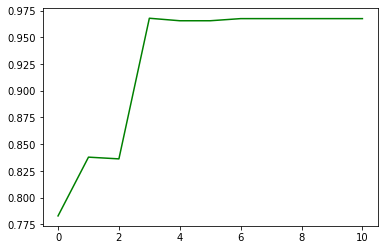


Destroying ga object



In [9]:
# Instantiate Genetic Algoritm class, which generates ga.population of size population_size
# The population's chromosome genes depend upon the classifier being used
# Different classifiers have different 'gene pools' (hyperparameter options)
dataset_path = "../Datasets/ISOT Botnet 2010/Pre-processed/isot_botnet.csv"

ga = kf_genetic_algorithm(classifier='DecisionTreeClassifier', dataset_path=dataset_path,
                          population_size=10, generations=10)

# Run Genetic Algorithm for N generations on given dataset
sorted_best_results = ga.run()

print("SORTED BEST RESULTS:")
print(sorted_best_results)

# Generate plot for the best fitness score in each generation
ga.plot_fitness_scores()

del ga

Generating Population of size:  10
Generated Inital Population:
[[116, 'entropy', 4, 3, 0.1492363836388228, None], [185, 'gini', 4, 3, 0.029706366590352584, None], [172, 'entropy', 4, 2, 0.09341214168685413, 'balanced'], [170, 'entropy', 3, 3, 0.27558195964280346, 'balanced'], [178, 'entropy', 2, 1, 0.27932803237605663, 'balanced'], [41, 'entropy', 2, 2, 0.17468416316215568, 'balanced'], [48, 'gini', 3, 3, 0.35217698337886894, 'balanced'], [46, 'gini', 2, 1, 0.3286143982143913, None], [111, 'gini', 2, 2, 0.203118828479678, 'balanced'], [62, 'gini', 3, 2, 0.0119287031686936, None]]

GENERATION =  0
score, parent1 =  (0.8876862214509463, [62, 'gini', 3, 2, 0.0119287031686936, None])
score, parent2 =  (0.8379974883331525, [185, 'gini', 4, 3, 0.029706366590352584, None])
Offspring1 =  [62, 'gini', 3, 3, 0.029706366590352584, None]
Offspring2 =  [185, 'gini', 4, 2, 0.0119287031686936, None]

New Population:
[62, 'entropy', 3, 3, 0.029706366590352584, None]
[62, 'gini', 3, 3, 0.0297063665903

score, parent1 =  (0.961541836048314, [85, 'entropy', 2, 2, 0.0006169648712688325, None])
score, parent2 =  (0.9615243786340935, [85, 'entropy', 4, 1, 0.0006169648712688325, None])
Offspring1 =  [85, 'entropy', 2, 1, 0.0006169648712688325, None]
Offspring2 =  [85, 'entropy', 4, 2, 0.0006169648712688325, None]

New Population:
[85, 'gini', 2, 1, 0.0006169648712688325, None]
[85, 'entropy', 4, 1, 0.0006169648712688325, None]
[85, 'gini', 2, 1, 0.0006169648712688325, None]
[85, 'entropy', 4, 2, 0.0006169648712688325, None]
[85, 'entropy', 4, 2, 0.0006169648712688325, None]
[178, 'entropy', 4, 3, 0.4452724033773271, 'balanced']
[72, 'gini', 3, 1, 0.29161463756756245, None]
[175, 'entropy', 2, 2, 0.15179356176340625, 'balanced']
[163, 'entropy', 4, 1, 0.004511836914929512, None]
[64, 'entropy', 2, 1, 0.21801257009817104, None]

GENERATION =  10
score, parent1 =  (0.9615165044280173, [85, 'entropy', 4, 2, 0.0006169648712688325, None])
score, parent2 =  (0.961014216620255, [85, 'entropy', 4, 

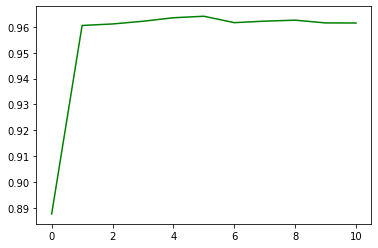


Destroying ga object



In [12]:
# Instantiate Genetic Algoritm class, which generates ga.population of size population_size
# The population's chromosome genes depend upon the classifier being used
# Different classifiers have different 'gene pools' (hyperparameter options)
dataset_path = "../Datasets/ISOT Botnet 2010/Pre-processed/isot_botnet.csv"

ga = kf_genetic_algorithm(classifier='RandomForestClassifier', dataset_path=dataset_path,
                          population_size=10, generations=10)

# Run Genetic Algorithm for N generations on given dataset
sorted_best_results = ga.run()

print("SORTED BEST RESULTS:")
print(sorted_best_results)

# Generate plot for the best fitness score in each generation
ga.plot_fitness_scores()

del ga